In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os  
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [3]:
%cd /content/gdrive/MyDrive/Kaggle

/content/gdrive/MyDrive/Kaggle


In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import pydotplus

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.metrics import accuracy_score, recall_score,precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

In [6]:
data = pd.read_csv("/content/gdrive/MyDrive/Kaggle/media prediction and its cost.csv")

In [7]:
data.head()

,food_category,food_department,food_family,store_sales(in millions),store_cost(in millions),unit_sales(in millions),promotion_name,sales_country,marital_status,gender,total_children,education,member_card,occupation,houseowner,avg_cars_at home(approx),avg. yearly_income,num_children_at_home,avg_cars_at home(approx).1,brand_name,SRP,gross_weight,net_weight,recyclable_package,low_fat,units_per_case,store_type,store_city,store_state,store_sqft,grocery_sqft,frozen_sqft,meat_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,media_type,cost
0,Breakfast Foods,Frozen Foods,Food,7.360,2.723,4.000,Bag Stuffers,USA,M,F,1.000,Partial High School,Normal,Skilled Manual,Y,1.000,$10K - $30K,1.000,1.000,Carrington,1.840,19.700,17.700,1.000,0.000,17.000,Deluxe Supermarket,Salem,OR,27694.000,18670.000,5415.000,3610.000,1.000,1.000,1.000,1.000,1.000,"Daily Paper, Radio",126.620
1,Breakfast Foods,Frozen Foods,Food,5.520,2.594,3.000,Cash Register Lottery,USA,M,M,0.000,Bachelors Degree,Silver,Professional,Y,4.000,$50K - $70K,0.000,4.000,Carrington,1.840,19.700,17.700,1.000,0.000,17.000,Deluxe Supermarket,Salem,OR,27694.000,18670.000,5415.000,3610.000,1.000,1.000,1.000,1.000,1.000,"Daily Paper, Radio",59.860
2,Breakfast Foods,Frozen Foods,Food,3.680,1.362,2.000,High Roller Savings,USA,S,F,4.000,Partial High School,Normal,Manual,N,1.000,$10K - $30K,0.000,1.000,Carrington,1.840,19.700,17.700,1.000,0.000,17.000,Deluxe Supermarket,Salem,OR,27694.000,18670.000,5415.000,3610.000,1.000,1.000,1.000,1.000,1.000,"Daily Paper, Radio",84.160
3,Breakfast Foods,Frozen Foods,Food,3.680,1.178,2.000,Cash Register Lottery,USA,M,F,2.000,High School Degree,Bronze,Manual,Y,2.000,$30K - $50K,2.000,2.000,Carrington,1.840,19.700,17.700,1.000,0.000,17.000,Deluxe Supermarket,Salem,OR,27694.000,18670.000,5415.000,3610.000,1.000,1.000,1.000,1.000,1.000,In-Store Coupon,95.780
4,Breakfast Foods,Frozen Foods,Food,4.080,1.428,3.000,Double Down Sale,USA,M,M,0.000,Partial High School,Bronze,Skilled Manual,N,2.000,$30K - $50K,0.000,2.000,Golden,1.360,7.120,5.110,0.000,1.000,29.000,Deluxe Supermarket,Salem,OR,27694.000,18670.000,5415.000,3610.000,1.000,1.000,1.000,1.000,1.000,Radio,50.790


In [10]:

def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat

    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]

    num_cols = [col for col in num_cols if col not in num_but_cat]
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(data)

In [11]:
df_c = data.copy()

df_c.drop(columns="store_state",inplace=True)

cat_cols, num_cols, cat_but_car = grab_col_names(df_c)

ohe_cols= [col for col in cat_cols if 12 >= df_c[col].nunique() > 5]

df_sscale = data.copy()
ss = StandardScaler()
df_sscale[['store_sales(in millions)','store_cost(in millions)']] = ss.fit_transform(df_sscale[['store_sales(in millions)','store_cost(in millions)']])



def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe


df_c = one_hot_encoder(df_c, ohe_cols)

def rare_encoding(df, column):
  freqs = df[column].value_counts(normalize=True)
  frequent_cat = [x for x in freqs.loc[freqs > 0.02].index.values]
  df[column] = np.where(df[column].isin(frequent_cat),df[column], "Rare")

for i in range(len(cat_but_car)):
  rare_encoding(df_c,cat_but_car[i])

all_cats = cat_but_car + cat_cols

drop_cols = [col for col in all_cats if data[col].nunique() > 12]

df_c.drop(columns=drop_cols,inplace=True)

label_enc_cols = [col for col in cat_cols if data[col].nunique() <= 5 and data[col].dtypes == 'O']

label_enc = LabelEncoder()

df_c["marital_status"] = label_enc.fit_transform(df_c["marital_status"])
df_c["gender"] = label_enc.fit_transform(df_c["gender"])
df_c["houseowner"] = label_enc.fit_transform(df_c["houseowner"])
df_c["member_card"] = label_enc.fit_transform(df_c["member_card"])
df_c["sales_country"] = label_enc.fit_transform(df_c["sales_country"])  
df_c["food_family"] = label_enc.fit_transform(df_c["food_family"])

df_c["store_type"] = label_enc.fit_transform(df_c["store_type"])
df_c["education"] = label_enc.fit_transform(df_c["education"])
df_c["occupation"] = label_enc.fit_transform(df_c["occupation"])



In [20]:
df_2 = df_c.copy()

In [21]:
df_c

,food_family,store_sales(in millions),store_cost(in millions),sales_country,marital_status,gender,education,member_card,occupation,houseowner,avg_cars_at home(approx),avg_cars_at home(approx).1,SRP,gross_weight,net_weight,recyclable_package,low_fat,units_per_case,store_type,store_sqft,grocery_sqft,frozen_sqft,meat_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost,avg. yearly_income_$10K - $30K,avg. yearly_income_$110K - $130K,avg. yearly_income_$130K - $150K,avg. yearly_income_$150K +,avg. yearly_income_$30K - $50K,avg. yearly_income_$50K - $70K,avg. yearly_income_$70K - $90K,avg. yearly_income_$90K - $110K,unit_sales(in millions)_1.0,unit_sales(in millions)_2.0,unit_sales(in millions)_3.0,unit_sales(in millions)_4.0,unit_sales(in millions)_5.0,unit_sales(in millions)_6.0,total_children_0.0,total_children_1.0,total_children_2.0,total_children_3.0,total_children_4.0,total_children_5.0,num_children_at_home_0.0,num_children_at_home_1.0,num_children_at_home_2.0,num_children_at_home_3.0,num_children_at_home_4.0,num_children_at_home_5.0
0,1,7.360,2.723,2,0,0,4,2,4,1,1.000,1.000,1.840,19.700,17.700,1.000,0.000,17.000,0,27694.000,18670.000,5415.000,3610.000,1.000,1.000,1.000,1.000,1.000,126.620,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1,1,5.520,2.594,2,0,1,0,3,3,1,4.000,4.000,1.840,19.700,17.700,1.000,0.000,17.000,0,27694.000,18670.000,5415.000,3610.000,1.000,1.000,1.000,1.000,1.000,59.860,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
2,1,3.680,1.362,2,1,0,4,2,2,0,1.000,1.000,1.840,19.700,17.700,1.000,0.000,17.000,0,27694.000,18670.000,5415.000,3610.000,1.000,1.000,1.000,1.000,1.000,84.160,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
3,1,3.680,1.178,2,0,0,2,0,2,1,2.000,2.000,1.840,19.700,17.700,1.000,0.000,17.000,0,27694.000,18670.000,5415.000,3610.000,1.000,1.000,1.000,1.000,1.000,95.780,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
4,1,4.080,1.428,2,0,1,4,0,4,0,2.000,2.000,1.360,7.120,5.110,0.000,1.000,29.000,0,27694.000,18670.000,5415.000,3610.000,1.000,1.000,1.000,1.000,1.000,50.790,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60423,2,2.760,1.325,2,0,0,4,2,4,1,1.000,1.000,2.760,19.600,18.600,1.000,0.000,26.000,3,22478.000,15321.000,4294.000,2863.000,1.000,0.000,0.000,0.000,0.000,95.250,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
60424,2,1.600,0.496,2,1,0,2,0,4,0,2.000,2.000,1.600,17.400,15.300,1.000,0.000,36.000,3,22478.000,15321.000,4294.000,2863.000,1.000,0.000,0.000,0.000,0.000,69.420,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
60425,2,5.520,2.539,2,0,1,2,0,2,1,3.000,3.000,2.760,19.600,18.600,1.000,0.000,26.000,3,22478.000,15321.000,4294.000,2863.000,1.000,0.000,0.000,0.000,0.000,67.510,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
60426,2,8.280,2.567,0,1,1,0,0,3,0,4.000,4.000,2.760,19.600,18.600,1.000,0.000,26.000,2,34452.000,27463.000,4193.000,2795.000,1.000,0.000,0.000,0.000,1.000,132.880,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0


In [34]:
y = df_2["houseowner"]
X = df_2.drop("houseowner", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)


## Ensemble Learning

In [35]:
dt = DecisionTreeClassifier(max_depth = 3,random_state=42)
dt.fit(X_train,y_train)
y_pred=dt.predict(X_test)

In [36]:
print(accuracy_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(precision_score(y_test, y_pred))

0.674002978652987
0.6744186046511628
0.7569111969111969


In [42]:

def tree_graph(model, col_names, file_name):
    tree_str = export_graphviz(model, feature_names=col_names, filled=True, out_file=None)
    graph = pydotplus.graph_from_dot_data(tree_str)
    graph.write_png(file_name)


In [43]:
tree_graph(model=dt, col_names=X.columns, file_name="dt_final.png")

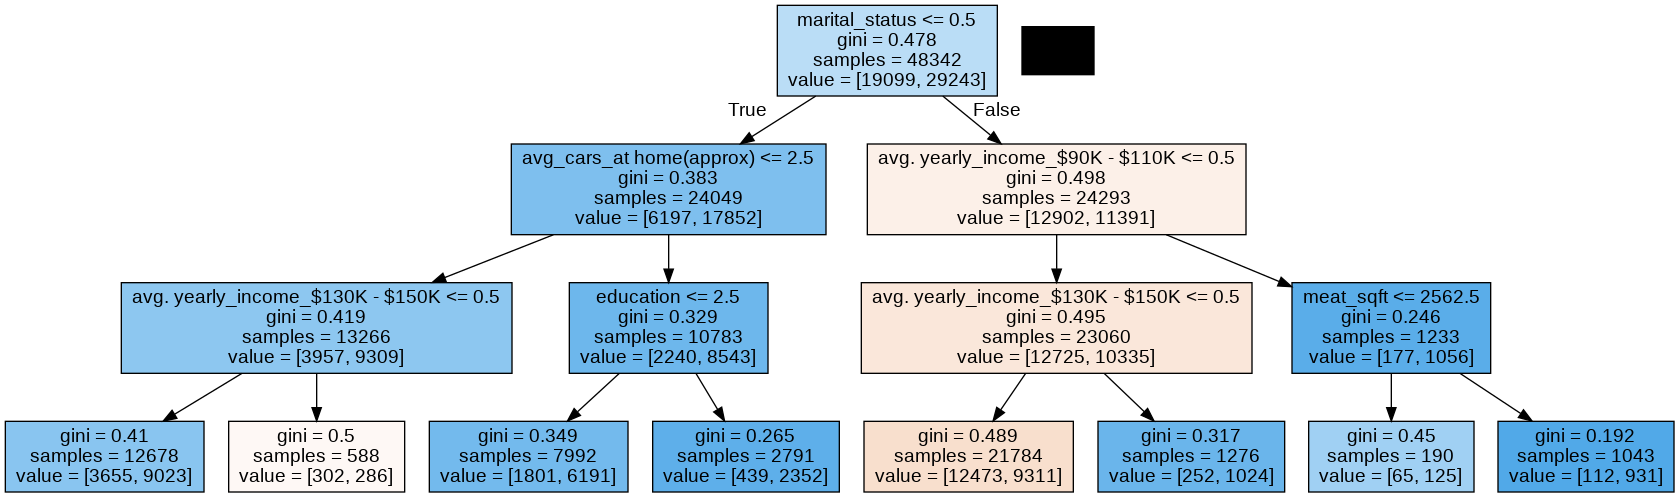

### **Bagging**


#### Repeats Stratified K-Fold n times with different randomization in each repetition.

In [65]:
bagging_model = BaggingClassifier()
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_validate(bagging_model, X, y, scoring=["accuracy", "f1", "roc_auc"], cv=cv, n_jobs=-1, error_score='raise')
# report performance

In [66]:
print(n_scores)

{'fit_time': array([12.85861993, 12.73811078,  9.03638601,  9.04725766, 11.22285414,
       10.57438064, 12.33210135, 11.61341023, 13.31928158, 13.77553821,
       12.37866712, 12.80875421,  9.03471732,  8.96887779,  9.2119081 ,
        9.21660209,  9.44443035,  9.7564795 ,  9.81881213,  9.85320711,
       10.73716068, 11.09111929, 11.58330512, 12.83795118, 13.30460596,
       13.59661913,  9.78793669, 10.00523591,  9.80967164,  8.46777916]), 'score_time': array([0.12569046, 0.11446571, 0.13238788, 0.12641978, 0.30826211,
       0.12807322, 0.12071562, 0.12186122, 0.111974  , 0.10572553,
       0.12221122, 0.10425043, 0.10767627, 0.13153815, 0.09596372,
       0.25684357, 0.22936511, 0.1075995 , 0.10622096, 0.1904664 ,
       0.11718822, 0.10319948, 0.10847473, 0.10874152, 0.24213243,
       0.09522438, 0.09955239, 0.10326862, 0.11995316, 0.07427859]), 'test_accuracy': array([0.96955155, 0.96574549, 0.96193943, 0.96558001, 0.96922059,
       0.96342876, 0.9674003 , 0.96475261, 0.964084

In [78]:
print(n_scores['test_accuracy'].mean())
print(n_scores['test_f1'].mean())
print(n_scores['test_roc_auc'].mean())

0.9664007846302279
0.9720426212156941
0.9934140270694815


### **Adaboost**

In [68]:
adaboost = AdaBoostClassifier()
cv_a = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores_a = cross_validate(adaboost, X,y, scoring=["accuracy", "f1", "roc_auc"], cv=cv_a, n_jobs=-1, error_score='raise')

In [69]:
print(n_scores_a)

{'fit_time': array([6.51985621, 6.54197812, 6.51657057, 6.42367053, 6.52774549,
       6.4902451 , 6.44497585, 6.44368148, 6.48981214, 6.46300435,
       6.4058857 , 6.4280138 , 6.53266287, 6.51837111, 6.47641087,
       6.52182579, 6.52427936, 6.54070473, 7.44202781, 7.49880099,
       6.53636146, 6.43424368, 6.55768037, 6.42745209, 6.55360556,
       6.46567845, 7.14001727, 7.37227225, 6.57947731, 6.56982255]), 'score_time': array([0.28232718, 0.29153371, 0.31093979, 0.30586147, 0.32525754,
       0.33179355, 0.28337312, 0.29113054, 0.29579282, 0.32035685,
       0.2877562 , 0.29139113, 0.2894485 , 0.30181289, 0.27658486,
       0.29022789, 0.28311896, 0.30664515, 0.29221487, 0.32058096,
       0.28764963, 0.28795004, 0.30794311, 0.32643437, 0.30286407,
       0.2982142 , 0.27627492, 0.29451323, 0.28154755, 0.1874187 ]), 'test_accuracy': array([0.68608307, 0.68906172, 0.68144961, 0.68194605, 0.68442826,
       0.68211153, 0.68591759, 0.68591759, 0.67874876, 0.69496855,
       0.67582

In [77]:
print(n_scores_a['test_accuracy'].mean())
print(n_scores_a['test_f1'].mean())
print(n_scores_a['test_roc_auc'].mean())

0.6844288839980505
0.7425142672228482
0.7092636371551897


### **Random Forest**

In [80]:
rf_model = RandomForestClassifier(random_state=17)

rf_params = {"max_depth": [3,5],
             "min_samples_split": [2, 5],
             "n_estimators": [200, 500]}

rf_best_grid = GridSearchCV(rf_model, rf_params, cv=5, n_jobs=-1).fit(X,y)


In [81]:
rf_best_grid.best_params_

{'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 500}

In [82]:
rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=17).fit(X_train,y_train)

cv_results = cross_validate(rf_final, X, y, cv=3, scoring=["accuracy", "f1", "roc_auc"])

In [83]:
print(cv_results['test_accuracy'].mean())
print(cv_results['test_f1'].mean())
print(cv_results['test_roc_auc'].mean())

0.6957536176822924
0.7523093269414476
0.7430740432079489
